# GraphWave aglorithm on a barbell graph

This demo features the algorithm GraphWave published in "Learning Structural Node Embeddings via Diffusion Wavelets" [https://arxiv.org/pdf/1710.10321.pdf]. GraphWave embeds the structural features of a node in a dense embeddings. We will demonstrate the use of GraphWave on a barbell graph demonstrating that structurally equivalent nodes have similar embeddings.

First, we load the required libraries.

In [1]:
import networkx as nx
from stellargraph.mapper import GraphWaveGenerator
from stellargraph import StellarGraph
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse.linalg import eigs
import tensorflow as tf
from tensorflow.keras import backend as K

### Graph construction

Next, we construct the barbel graph, shown below. The barbell graph consists of 2 fully connected graphs (at the 'ends' of the graph) connected by a chain of nodes. All nodes in the fully connected ends are strucuturally equivalent, as the are opposite nodes in the chain. A good strucutural embedding algorithm should embed equivalent nodes close togethed in the embedding space.

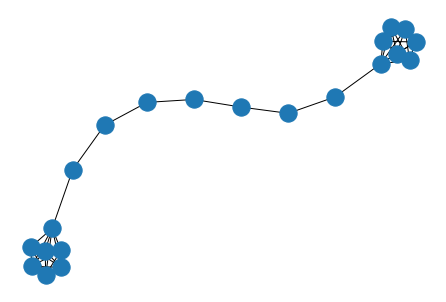

In [2]:
m1 = 7
m2 = 7
gnx = nx.barbell_graph(m1=m1, m2=m2)
nx.draw(gnx)

### GraphWave embedding calculation

Now, we're ready to calculate the GraphWave embeddings. We need to specify the points to sample the characteristic function. We need to specify: 

- the wavelet `scales` to the use. This is a graph dependant hyperparameter. Experiment with different values or use the `scales="auto"` option
- the number of eigen vectors to use `num_eigenvecs`. A larger number of eigenvectors will yield better results but is more computationally expensive. `num_eigenvecs=-1` will calculate all eigenvectors.
- the `sample_points` at which to sample the characteristic function. This should be: `sample_points=np.linspace(0, max_val, number_of_samples)` and is graph dependant.

In [3]:
G = StellarGraph(gnx)
sample_points = np.linspace(0, 100, 32).astype(np.float32)

generator = GraphWaveGenerator(G, scales=[10.0, 30.0], num_eigenvecs=-1,)

embeddings_dataset = generator.flow(
    node_ids=G.nodes(), sample_points=sample_points, batch_size=1, repeat=False
)

embeddings = [x.numpy() for x in embeddings_dataset]

### Visualation

The nodes are coloured by their structural role, e.g. in the connected component, 1st node in the chain, 2nd node in the chain etc. We can see that all nodes of the same colour completely overlap in this visualation, indicating that structurally equivalent nodes are very close in the embedding space.

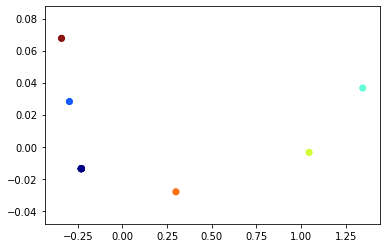

In [4]:
classes = [0,] * len(gnx.nodes)
classes[m1 - 1] = 1
classes[m1 + m2] = 1
classes[m1 : (m1 + m2)] = list(abs(x) + 2 for x in range(m2 // 2, -m2 // 2, -1))

trans_emb = PCA(n_components=2).fit_transform(np.vstack(embeddings))

plt.scatter(
    trans_emb[:, 0], trans_emb[:, 1], c=classes, cmap="jet", alpha=0.7,
)
plt.show()